In [54]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# model summary info
from torchsummary import summary

import matplotlib.pyplot as plt

In [55]:
nGauss = 5000
imgSize = 91

x = np.linspace(-4, 4, imgSize)
X, Y = np.meshgrid(x,x)

widths = np.linspace(2, 20, nGauss)

images = torch.zeros(nGauss, 1, imgSize, imgSize)
images_occluded = torch.zeros(nGauss, 1, imgSize, imgSize)

for i in range(nGauss):
    ro = 1.5*np.random.randn(2)
    G = np.exp(-((X-ro[0])**2 + (Y - ro[1])**2) / widths[i])

    G = G + np.random.randn(imgSize, imgSize)/5

    i1 = np.random.choice(np.arange(2,28))
    i2 = np.random.choice(np.arange(2,3))
    images[i, :, :, :] = torch.Tensor(G).view(1, imgSize, imgSize)    
    if np.random.randn()>0:
        G[i1:i1+i2,] = 1
    else:
        G[:, i1:i1+i2] = 1
    
    images_occluded[i, :, :, :] = torch.Tensor(G).view(1, imgSize, imgSize)

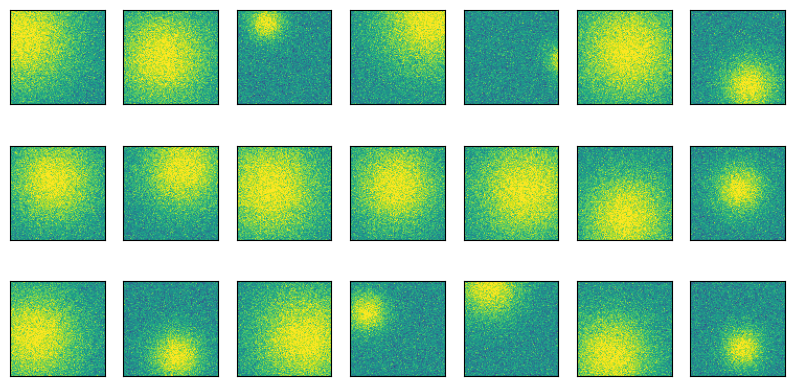

In [56]:
fig, axs = plt.subplots(3,7,figsize=(10, 5))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nGauss)
    G = np.squeeze(images[whichpic, :, :])
    ax.imshow(G,vmin=-1, vmax=1)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [57]:
class myL1Loss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, yHat, y):
        return torch.mean(torch.abs(yHat - y))


class myL2AveLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, yHat, y):
        return torch.mean((yHat - y) ** 2) + torch.abs(torch.mean(yHat))


class myCorrLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, yHat, y):
        return -(torch.sum( (yHat - torch.mean(yHat)) * (y - torch.mean(y)) )) / (
            (torch.numel(yHat) - 1) * torch.std(yHat) * torch.std(y)
        )

In [58]:
def makeTheNet(loss_func=myL1Loss):
    class gausnet(nn.Module):
        def __init__(self):
            super().__init__()

            self.enc = nn.Sequential(
                nn.Conv2d(1, 6, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
                # nn.AvgPool2d(2,2),
                nn.Conv2d(6, 4, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
                nn.Conv2d(4, 2, 3, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),
                # nn.AvgPool2d(2,2),
            )

            self.dec = nn.Sequential(
                nn.ConvTranspose2d(2, 4, 3, 2, padding=1, output_padding=1),
                nn.ReLU(),
                nn.ConvTranspose2d(4, 6, 3, 2),
                nn.ReLU(),
                nn.ConvTranspose2d(6, 1, 3, 2),
            )

        def forward(self, x):
            return self.dec(self.enc(x))

    net = gausnet()
    lossfun = loss_func()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
    return net, lossfun, optimizer

 
torch.Size([10, 1, 91, 91])


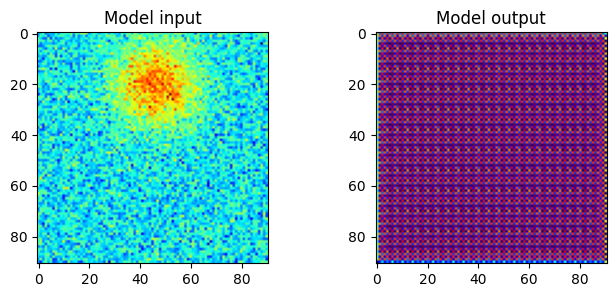

In [59]:
net, lossfun, optimizer = makeTheNet()

yHat = net(images[:10, :, :, :])
print(" ")
print(yHat.shape)

fig, ax = plt.subplots(1,2,figsize=(8,3))
ax[0].imshow(torch.squeeze(images[0,0,:,:]).detach(), cmap="jet")
ax[0].set_title('Model input')
ax[1].imshow(torch.squeeze(yHat[0,0,:,:]).detach(), cmap="jet")
ax[1].set_title("Model output")
plt.show()

In [60]:
summary(net, (1, imgSize, imgSize), device="cpu")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
              ReLU-2            [-1, 6, 91, 91]               0
         MaxPool2d-3            [-1, 6, 45, 45]               0
            Conv2d-4            [-1, 4, 45, 45]             220
              ReLU-5            [-1, 4, 45, 45]               0
         MaxPool2d-6            [-1, 4, 22, 22]               0
            Conv2d-7            [-1, 2, 22, 22]              74
              ReLU-8            [-1, 2, 22, 22]               0
         MaxPool2d-9            [-1, 2, 11, 11]               0
  ConvTranspose2d-10            [-1, 4, 22, 22]              76
             ReLU-11            [-1, 4, 22, 22]               0
  ConvTranspose2d-12            [-1, 6, 45, 45]             222
             ReLU-13            [-1, 6, 45, 45]               0
  ConvTranspose2d-14            [-1, 1,

In [61]:
def train_the_model(loss_func):
    numepochs = 500
    net,lossfun,optimizer = makeTheNet(loss_func)
    losses = torch.zeros(numepochs)
    for epochi in range(numepochs):
        pics2use = np.random.choice(nGauss,size=32,replace=False)
        X = images[pics2use, :, :, :]
        X_occluded = images_occluded[pics2use, :, :, :]
        yHat = net(X_occluded)
        loss = lossfun(yHat, X)
        losses[epochi] = loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return losses, net

In [62]:
lossesL1, netL1 = train_the_model(myL1Loss)


In [63]:
lossesL2, netL2 = train_the_model(myL2AveLoss)


In [67]:
lossesCorr, netCorr = train_the_model(myCorrLoss)


Text(0.5, 1.0, 'Model loss(final loss=-0.820)')

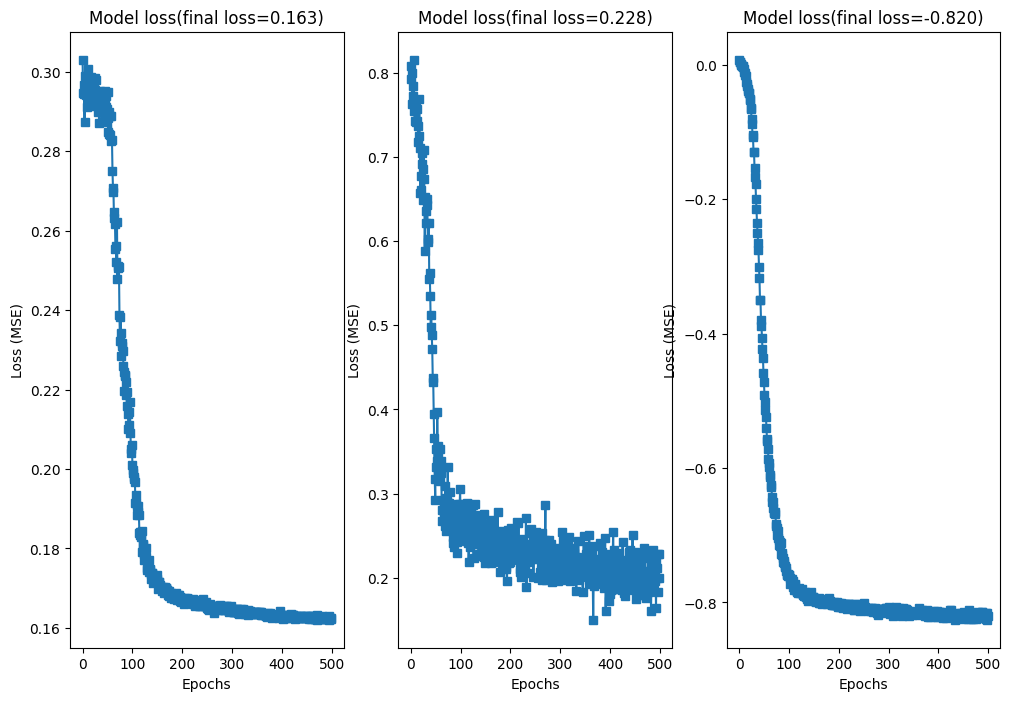

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12,8))
ax[0].plot(lossesL1, 's-', label="Train")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss (MSE)")
ax[0].set_title(f"Model loss(final loss={lossesL1[-1]:.3f})")
ax[1].plot(lossesL2, 's-', label="Train")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss (MSE)")
ax[1].set_title(f"Model loss(final loss={lossesL2[-1]:.3f})")
ax[2].plot(lossesCorr, 's-', label="Train")
ax[2].set_xlabel("Epochs")
ax[2].set_ylabel("Loss (MSE)")
ax[2].set_title(f"Model loss(final loss={lossesCorr[-1]:.3f})")

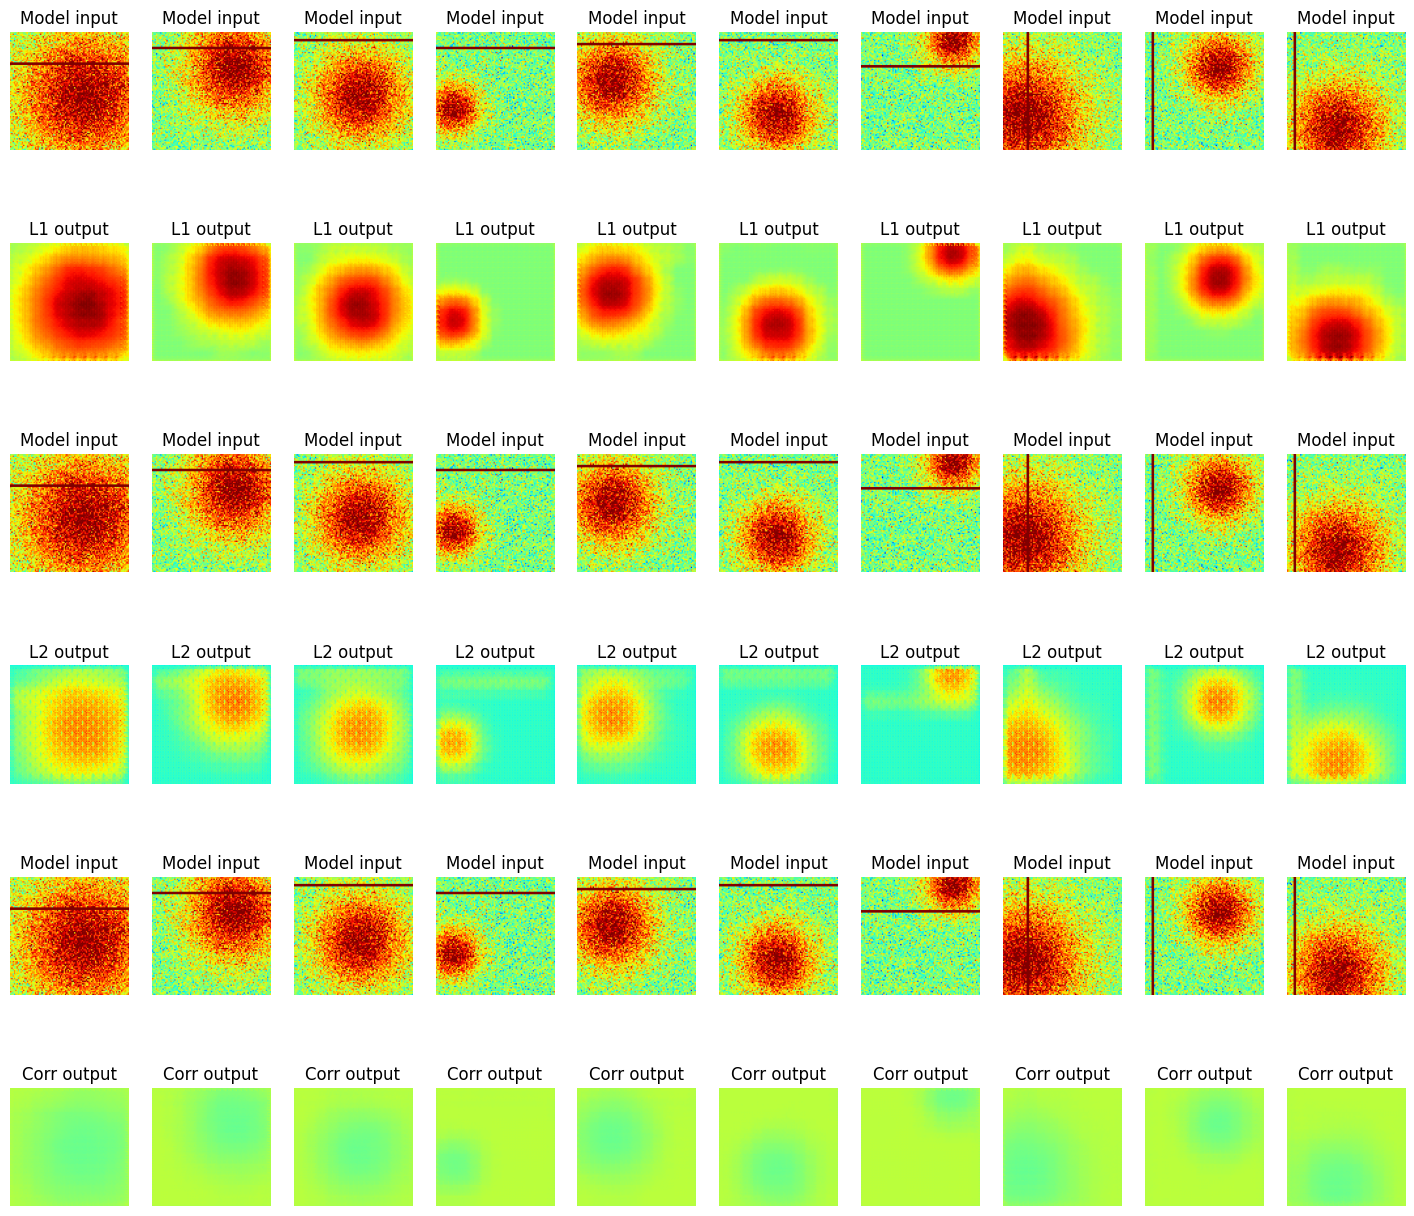

In [69]:
pics2use = np.random.choice(nGauss, size=32, replace=False)
X = images_occluded[pics2use, :, :, :]
yHatL1 = netL1(X)
yHatL2 = netL2(X)
yHatCorr = netCorr(X)

fig, axs = plt.subplots(6,10,figsize=(18,16))

for i in range(10):
    G = torch.squeeze(X[i, 0, :, :]).detach()
    O = torch.squeeze(yHatL1[i,0,:,:]).detach()
    axs[0,i].imshow(G, vmin=-1, vmax=1, cmap='jet')
    axs[0,i].axis('off')
    axs[0,i].set_title('Model input')
    # axs[0,i].set_
    axs[1,i].axis('off')
    axs[1,i].set_title("L1 output")
    

    axs[1,i].imshow(O,vmin=-1,vmax=1,cmap='jet')

for i in range(10):
    G = torch.squeeze(X[i, 0, :, :]).detach()
    O = torch.squeeze(yHatL2[i,0,:,:]).detach()
    axs[2,i].imshow(G, vmin=-1, vmax=1, cmap='jet')
    axs[2,i].axis('off')
    axs[2,i].set_title('Model input')

    axs[3,i].axis('off')
    axs[3,i].set_title("L2 output")
    

    axs[3,i].imshow(O,vmin=-1,vmax=1,cmap='jet')

for i in range(10):
    G = torch.squeeze(X[i, 0, :, :]).detach()
    O = torch.squeeze(yHatCorr[i,0,:,:]).detach()
    axs[4,i].imshow(G, vmin=-1, vmax=1, cmap='jet')
    axs[4,i].axis('off')
    axs[4,i].set_title('Model input')

    axs[5,i].axis('off')
    axs[5,i].set_title("Corr output")
    

    axs[5,i].imshow(O,vmin=-1,vmax=1,cmap='jet')
